# Severstal: Steel Defect Detection

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
import fastai.utils
fastai.utils.show_install()



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.58
fastprogress  : 0.1.21
torch         : 1.2.0
nvidia driver : 435.21
torch cuda    : 10.0.130 / is available
torch cudnn   : 7602 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.15.0-1051-aws-x86_64-with-debian-buster-sid
distro        : #53-Ubuntu SMP Wed Sep 18 13:35:53 UTC 2019
conda env     : base
python        : /home/ubuntu/anaconda3/bin/python
sys.path      : /home/ubuntu/ds_scribbles
/home/ubuntu/anaconda3/lib/python37.zip
/home/ubuntu/anaconda3/lib/python3.7
/home/ubuntu/anaconda3/lib/python3.7/lib-dynload

/home/ubuntu/.local/lib/python3.7/site-packages
/home/ubuntu/anaconda3/lib/python3.7/site-packages
/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/ubuntu/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear

In [4]:
! pip install opencv-python

In [5]:
import cv2

## Getting the data

In [6]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /home/ubuntu/anaconda3/lib/python3.7/site-packages (1.5.6)


In [7]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [8]:
path = Config.data_path()/'severstal-steel-defect-detection'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection')

In [9]:
! kaggle competitions download -c severstal-steel-defect-detection -f train.csv -p {path}  
! kaggle competitions download -c severstal-steel-defect-detection -f train_images.zip -p {path}  
! kaggle competitions download -c severstal-steel-defect-detection -f test_images.zip -p {path}  
! unzip -q -n {path}/train_images.zip -d {path}/train_images
! unzip -q -n {path}/test_images.zip -d {path}/test_images
! unzip -q -n {path}/train.csv.zip -d {path}

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_images.zip: Skipping, found more recently modified local copy (use --force to force download)
test_images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
! chmod 555 '/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train.csv'

## Setup

In [11]:
path_img = path/'train_images'

In [12]:
path_test = path/'test_images'

In [13]:
path_lbl = path/'labels'

## Data Ingestion

In [14]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


## Process labels

In [15]:
def process_csv(path, csv):
    
    train_df = pd.read_csv(path/csv)
    
    train_df['label'] = train_df.apply(lambda x : x['ImageId_ClassId'].split('_')[-1], axis=1)
    train_df['image_id'] = train_df.apply(lambda x : x['ImageId_ClassId'].split('_')[0], axis=1)

    proc_train_df = train_df.pivot(index='image_id', columns='label', values='EncodedPixels').reset_index(drop=False)

    proc_train_df = proc_train_df.fillna(value=' ')
    
    return proc_train_df

In [16]:
proc_train_df = process_csv(path, 'train.csv')

In [17]:
proc_train_df.head()

label,image_id,1,2,3,4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [18]:
## Save RLEs as PNGs

In [17]:
! mkdir '/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels'

In [18]:
def make_labels_rle(path, train, proc_train_df, labels):
    for index, row in proc_train_df.iterrows():
        save_rle_label_image(path, row, train, labels)

In [19]:
def save_rle_label_image(path, mask_df, train, labels):
    image_id, rles = mask_df[0], mask_df[1:]
    image_fn = re.search('(.*?)\.jpg', image_id).group(1)+'.png'
    shape = open_image(path/train/image_id).shape[-2:]
    final_mask = torch.zeros((1, *shape))
    for k, rle in enumerate(rles):
        if isinstance(rle, str):
            mask = open_mask_rle(rle, shape).px.permute(0, 2, 1)
            final_mask += (k+1)*mask
    mask_img = image2np(final_mask.data).astype(np.uint8)
    PIL.Image.fromarray(mask_img).save(path/labels/image_fn, 'png')

In [23]:
make_labels_rle(path, 'train_images', proc_train_df, path_lbl)

## Explore 

In [12]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/cf1152c44.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/b54038841.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/1c97d1861.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/6ac1d05d3.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/f0b2483fa.jpg')]

In [13]:
lbl_names = get_image_files(path_lbl)
lbl_names[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/1863eb011.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/62cf0b008.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/1c2a39896.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/8bfc35309.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/e6207db1a.png')]

torch.Size([3, 256, 1600])


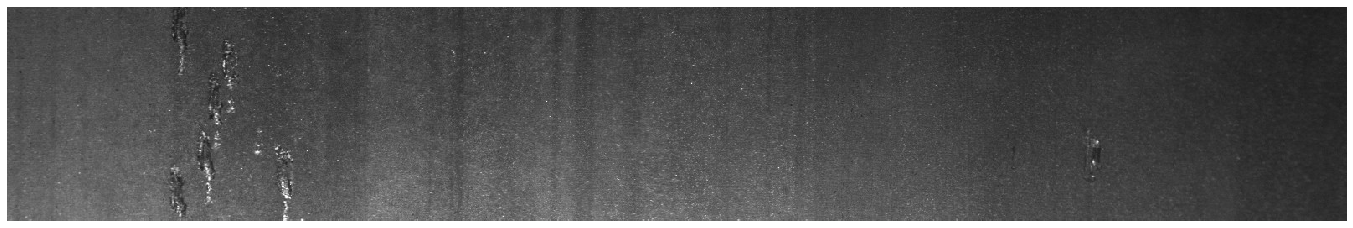

In [14]:
img_f = fnames[3]
img = open_image(img_f)
print(img.shape)
img.show(figsize=(24,24))

{0, 3}


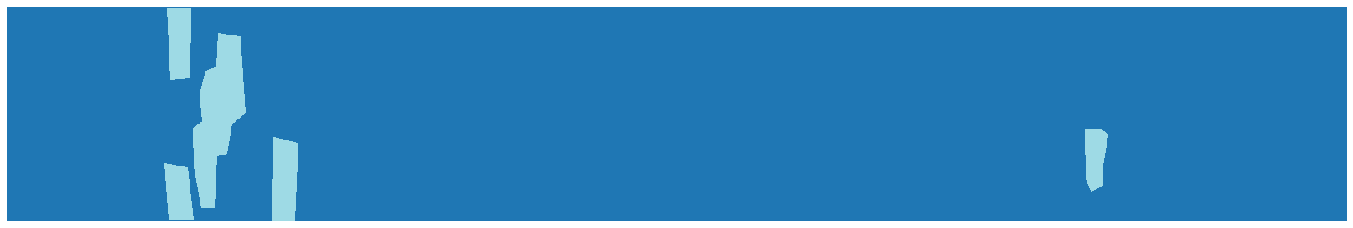

In [15]:
mask = open_mask(get_y_fn(img_f))
print(set(mask.data.numpy().flatten()))
mask.show(figsize=(24,24), alpha=1)

In [16]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 256, 1600]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

## Setup Data Block

In [45]:
codes = [0,1,2,3,4]

In [11]:
get_y_fn = lambda x: (path_lbl/f'{x.stem}').with_suffix('.png')

In [46]:
from fastai.utils.mem import *
size = src_size//2
print(size)

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

[128 800]
using bs=8, have 11151MB of GPU RAM free


In [19]:
size = size//2
print(size)

[ 64 400]


In [21]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(valid_pct=0.2)
        .label_from_func(get_y_fn, classes=codes))

In [22]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

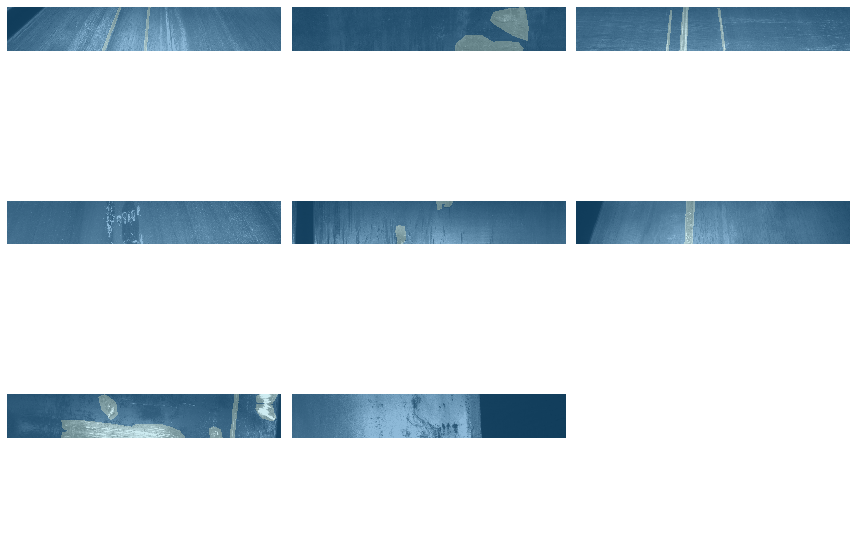

In [23]:
data.show_batch(3, figsize=(12,9))

## Create Learner

In [36]:
arch = models.resnet18

In [37]:
from fastai.metrics import dice
learn = unet_learner(data, arch, metrics=[dice], loss_func=BCEWithLogitsFlat())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


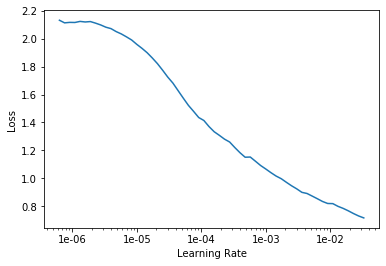

In [38]:
lr_find(learn)
learn.recorder.plot()

In [39]:
lr=1e-04

In [40]:
print(lr)

0.0001


In [41]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,time
0,0.120836,0.105573,0.513727,03:48
1,0.094524,0.091609,0.814645,03:43
2,0.090748,0.083514,1.194012,03:42
3,0.094708,0.084035,0.987881,03:44
4,0.085171,0.072325,1.401402,03:43


In [42]:
learn.save('stage-1-rn18')

In [43]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


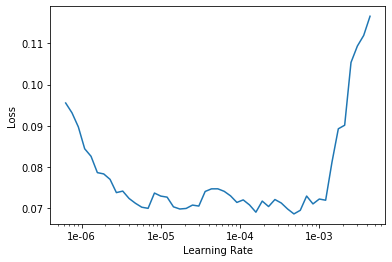

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
# Pick a value just before the slope goes upward, then 10x smaller
lr = 1e-04
print(lr)

0.0001


In [46]:
# LR / 5 or LR / 10 - Discriminate learning
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,dice,time
0,0.076451,0.070916,1.354732,03:54
1,0.081195,0.069432,1.470850,03:57
2,0.076071,0.070064,1.387026,03:56
3,0.080098,0.067003,1.530236,03:56
4,0.074872,0.066339,1.502766,03:56


In [47]:
learn.save('stage-2-rn18')

In [54]:
size = size*2
print(size)

[ 64 400]


In [57]:
# Resize data
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 64, 400])

In [58]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


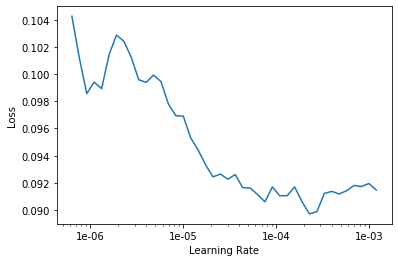

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
lr=1e-05/5

In [61]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.086889,0.079472,1.557580,07:49
1,0.078923,0.073919,1.706381,07:42
2,0.076980,0.071398,1.748325,07:40
3,0.075141,0.070566,1.775537,07:41
4,0.073912,0.070268,1.776918,07:41


In [62]:
learn.save('stage-1-64-rn18')

In [63]:
learn.unfreeze()

In [64]:
# learn.fit_one_cycle(5, slice(1e-5, lr/5))

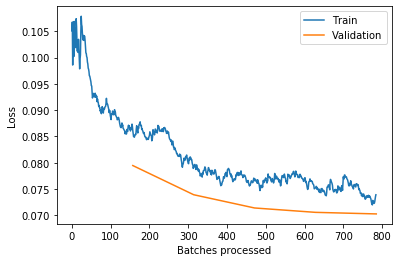

In [65]:
learn.recorder.plot_losses()

In [348]:
size=src_size
size

array([ 256, 1600])

In [349]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 1600])

In [30]:
# learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-05/5

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-256-rn50')

In [75]:
learn.export()

## Inference

In [49]:
tnames = get_image_files(path_test)
tnames[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/73d60f24f.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/f99381ed5.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/c4405bef9.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/b991340c8.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/1ba63ec01.jpg')]

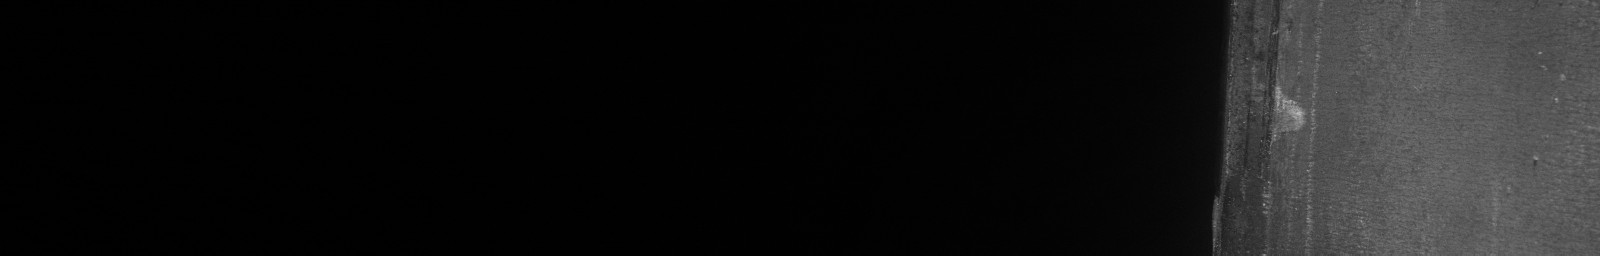

In [58]:
# Sample test image
img = open_image(path_test/'f99381ed5.jpg')
img

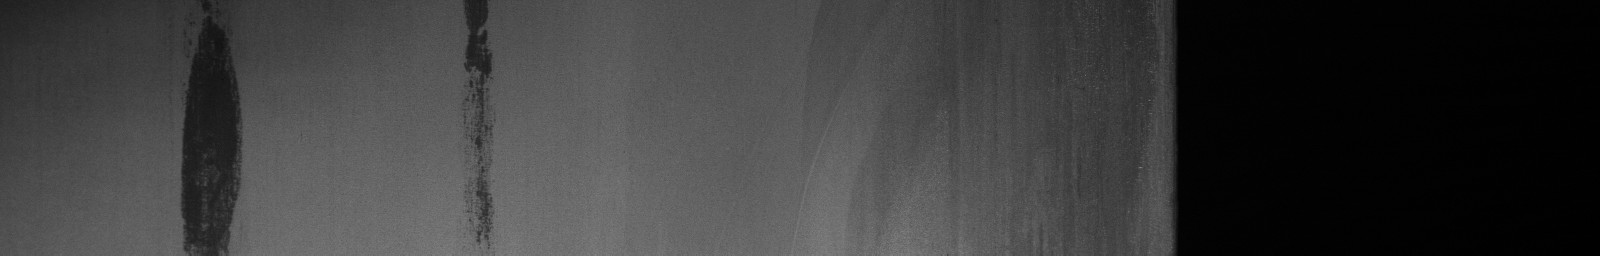

In [50]:
open_image(tnames[0])

In [21]:
# Setup test data
test_data = ItemList.from_folder(path/'test_images')

In [22]:
# Load learner
learn = load_learner(path, test=test_data, tfm_y=False)

In [ ]:
# Predict
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [18]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [20]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability.cpu().data.numpy(), threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((64, 400), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [ ]:
def get_rle(pred, thresh=0.2, min_size=50, scale=4):
    '''Get RLEs'''
    pred_mask, test_num = post_process(pred, thresh, min_size=min_size)
    pred_mask = pred_mask.repeat(scale, axis=0).repeat(scale, axis=1)
    rle  = mask2rle(pred_mask)
    return rle

In [19]:
min_size = 100

In [74]:
learn.data.classes

[0, 1, 2, 3, 4]

In [296]:
src_size

array([ 256, 1600])

In [59]:
fnames = [('_'.join([i.name, str(c)])) for i in learn.data.test_ds.items for c in learn.data.classes]

In [68]:
preds_list = [get_rle(j) for pred in preds for _,j in enumerate(pred)]

CPU times: user 34.7 s, sys: 170 ms, total: 34.9 s
Wall time: 31.5 s


In [86]:
df = pd.DataFrame({'ImageId_ClassId':fnames, 'EncodedPixels':preds_list}, columns=['ImageId_ClassId', 'EncodedPixels'])

In [89]:
df = df[~df.ImageId_ClassId.str.contains("_0")]

In [90]:
df.head()

,ImageId_ClassId,EncodedPixels
1,73d60f24f.jpg_1,
2,73d60f24f.jpg_2,
3,73d60f24f.jpg_3,118809 60 119065 60 119321 60 119577 60 119825...
4,73d60f24f.jpg_4,48161 36 48201 4 48305 20 48417 36 48457 4 485...
6,f99381ed5.jpg_1,


In [92]:
df.to_csv('submission.csv', index=False)